In [2]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F

from utils.system import AAC
from utils.controller import *
from utils.dataset import Dataset
from utils.estimator import *
from utils.normalizer import *

In [3]:
class OSELM_edited:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
                
        self.w_ik = 1*np.random.randn(input_dim,hidden_dim)
        self.P = np.zeros((2*self.hidden_dim, 2*self.hidden_dim))
        self.Omega = np.zeros((2*self.hidden_dim, self.output_dim))
    
    def predict(self, x, u, data_points = 1):
        """
        x: datapoints * i
        u: datapoints * 1
        """

        
        H = []
        # H[n]
        for n in range(data_points):   
            h = []
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(x[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))
                h.append(g) 
            
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(x[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))*u[n,0].item()
                h.append(g) 
            h = np.array(h)
            H.append(h)
            
        H = np.array(H)
        
        y = np.matmul(H, self.Omega)
        
        return y, H
        
    def predict_casadi(self,x, u):
        
        y = 0 

        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                g += x[i]* self.w_ik[i,k]

            g = sigmoid(g)
            y += self.Omega[k,0]*g
            
        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                g += x[i]* self.w_ik[i,k]

            g = sigmoid(g)
            y += self.Omega[self.hidden_dim +k,0]*g*u

        return y        
        
    def training_first(self, xs, us, ys):

        if xs.ndim > 2:
            xs = xs.squeeze()
        
        data_points, _ = np.shape(xs)

        _, H = self.predict(xs, us, data_points)
     
        # Calculate P0 and T0
        self.P = pinv2(np.matmul(H.T, H))
       
        self.Omega = np.matmul(self.P, np.matmul(H.T, ys))
        
        


    def training(self,x, u, y):
        data_points, _ = np.shape(x)
        _, H = self.predict(x, u, data_points)

        if data_points == 1:
            self.P = self.P - np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P))) / (1 + (np.matmul(H, np.matmul(self.P,H.T))))
            self.Omega = self.Omega + np.matmul( self.P, np.matmul(H.T, y - np.matmul(H, self.Omega)))
        else:
            left = np.matmul(self.P, H.T)
            center = pinv2(np.eye(data_points) + np.matmul(H, left))
            right = np.matmul(H, self.P)
            
            self.P = self.P - np.matmul(left, np.matmul(center, right))
            right = (y - np.matmul(H, self.Omega))
            self.Omega = self.Omega + np.matmul(left, right)

    def get_P(self):
        return self.P
    
    def get_Omega(self):
        return self.Omega
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class OSELM_nonaffine_:
    def __init__(self, input_dim, hidden_dim, output_dim, learned_ratio, dt):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim 
        self.dt = dt
        self.learned_ratio = learned_ratio

        self.e_fg = OSELM_edited(input_dim, hidden_dim, output_dim)

        self.train_input_x = []
        self.train_input_u = []
        self.train_output = []

        self.first_time = True


    def forward(self, x, u, t):
        if t / self.dt > self.learned_ratio*self.hidden_dim:
            dhe = self.e_fg.predict_casadi(np.array(x), u)
        else:
            dhe = 0

        return dhe


    def training(self, x, k, dhe_real, t, ef = 0, eg = 0):
        """
        x: N * 3
        k: N * 1
        dhe_real: N * 1
        """

        if t / self.dt < self.learned_ratio*self.hidden_dim:
            self.train_input_x.append(x[-1,:])
            self.train_input_u.append(k[-1,:])
            self.train_output.append(dhe_real[-1,:]) # [ef, eg] = dhe * pinv(u_ext)
        else:
            if self.first_time:         
                self.e_fg.training_first(np.array(self.train_input_x),np.array(self.train_input_u), np.array(self.train_output))
                self.first_time = False
            else:
                self.e_fg.training(x, k, dhe_real)

In [59]:
b = np.zeros([3,3])
np.vstack([b,b])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [73]:
f,d =np.shape(b)

In [74]:
f

3

In [4]:
class Dummy:
    def __init__(self):
        self.var = 0

    def forward(self, x, u, t):
        return 0

In [5]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return np.array([p0, v0, z0])

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        
        return dx
    

In [10]:
dt = 0.02
simTime = 10

# Real parameters
v_lead = 20
v_des = 23
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0.
v0 = 22
z0 = 35


x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

# Parameter ELM
n_hidden = 50

In [7]:
from collections import deque
pts = deque(maxlen=2)
pts.append(b)

NameError: name 'b' is not defined

In [87]:
np.vstack(batches['x'])

array([[ 1.74070321, -0.1991273 , -1.3982819 ],
       [ 1.73991614, -0.22940154, -1.4154928 ],
       [ 1.73911261, -0.25974524, -1.43218294],
       [ 1.73829293, -0.29014678, -1.44835513],
       [ 1.73745761, -0.32059475, -1.46401185],
       [ 1.73660746, -0.35107798, -1.47915734],
       [ 1.73574239, -0.38158642, -1.49379605],
       [ 1.73486313, -0.41210913, -1.50793281],
       [ 1.73397027, -0.44263528, -1.52157224],
       [ 1.73306391, -0.47315414, -1.53471954]])

In [82]:
def cle(my_queue):
    

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [19]:
aac = AAC(m, c_d, f0, f1, f2, v_lead)

cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

derivator = Derivator(dt)

norm_x = WelfordNormalizerOne((3,))
norm_u = WelfordNormalizerOne((1,))
norm_dhe = WelfordNormalizerOne((1,))

normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}

batch_size = 1
batch_x = deque(maxlen=batch_size)
batch_u = deque(maxlen=batch_size)
batch_dhe = deque(maxlen=batch_size)

batches = {'x':batch_x, 'u':batch_u, 'dhe':batch_dhe}

learned_ratio = 2.5#1.6
estimator = OSELM_nonaffine(4, n_hidden, 1, learned_ratio, dt) # Change to 3

xs = []
us = []
Vs = []
hs = []
dhe_reals = []
dhes = []

slacks = []

weights = 0.2


xs_lst = []
us_lst = []
Vs_lst = []
hs_lst = []
dhe_reals_lst = []
dhes_lst = []

slacks_lst = []


train_input, train_output = [], []

train_input_x, train_input_u, train_output = [], [], []

x = [0, 20, 40]#sample_initial_state()


first_time = True

# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)

if simTime / dt < learned_ratio*n_hidden:
    raise ValueError('simTime / dT: {} must be larger than n_hidden: {}'.format(simTime / dt, n_hidden))

laps = 6
pbar = tqdm(total=laps*simTime/dt)


dlst = np.linspace(32,40,laps).round(2)

for z0 in dlst:
    x0 = [0,20,z0]
    x = x0
    xs = []
    us = []
    Vs = []
    hs = []
    dhe_reals = []
    dhes = []

    slacks = []


    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(n=1)

        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
        u_ref = u_ref[0,0]

        #saw =  -1 if np.sin(t)< 0 else 1
        #aac.v_lead = v_lead  + 5*saw
        
        
        aac.v_lead = v_lead + 5*np.sin(1.5*t)

        #print(k)
        k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t, normalizer) 


        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)

        dh_real = derivator.update(h)

        dhe_real = dh_real - dh

        dhe_real_norm = np.array([normalizer['dhe'].update(dhe_real)])
        x_norm = np.expand_dims(normalizer['x'].normalize(x), axis = 0)
        k_norm = np.expand_dims(normalizer['u'].normalize(k), axis = 0)

        batches['x'].append(x_norm)
        batches['u'].append(k_norm)
        batches['dhe'].append(dhe_real_norm)

        estimator.training(np.vstack(batches['x']), np.vstack(batches['u']), np.vstack(batches['dhe']), t)
        #estimator.training(x_norm, k_norm, dhe_real_norm[0], t)



        xs.append(x)
        us.append(k)
        Vs.append(V)
        hs.append(h)
        dhes.append(dhe)
        dhe_reals.append(dhe_real)
        slacks.append(slack_sol)

        x = x_n
        
    xs_lst.append(xs)
    us_lst.append(us)
    Vs_lst.append(Vs)
    hs_lst.append(hs)
    dhes_lst.append(dhes)
    dhe_reals_lst.append(dhe_reals)

    slacks_lst.append(slacks)

pbar.close()

100%|██████████| 3000/3000.0 [00:44<00:00, 66.96it/s] 


In [12]:
normalizer['dhe'].mean

array([0.5102739], dtype=float32)

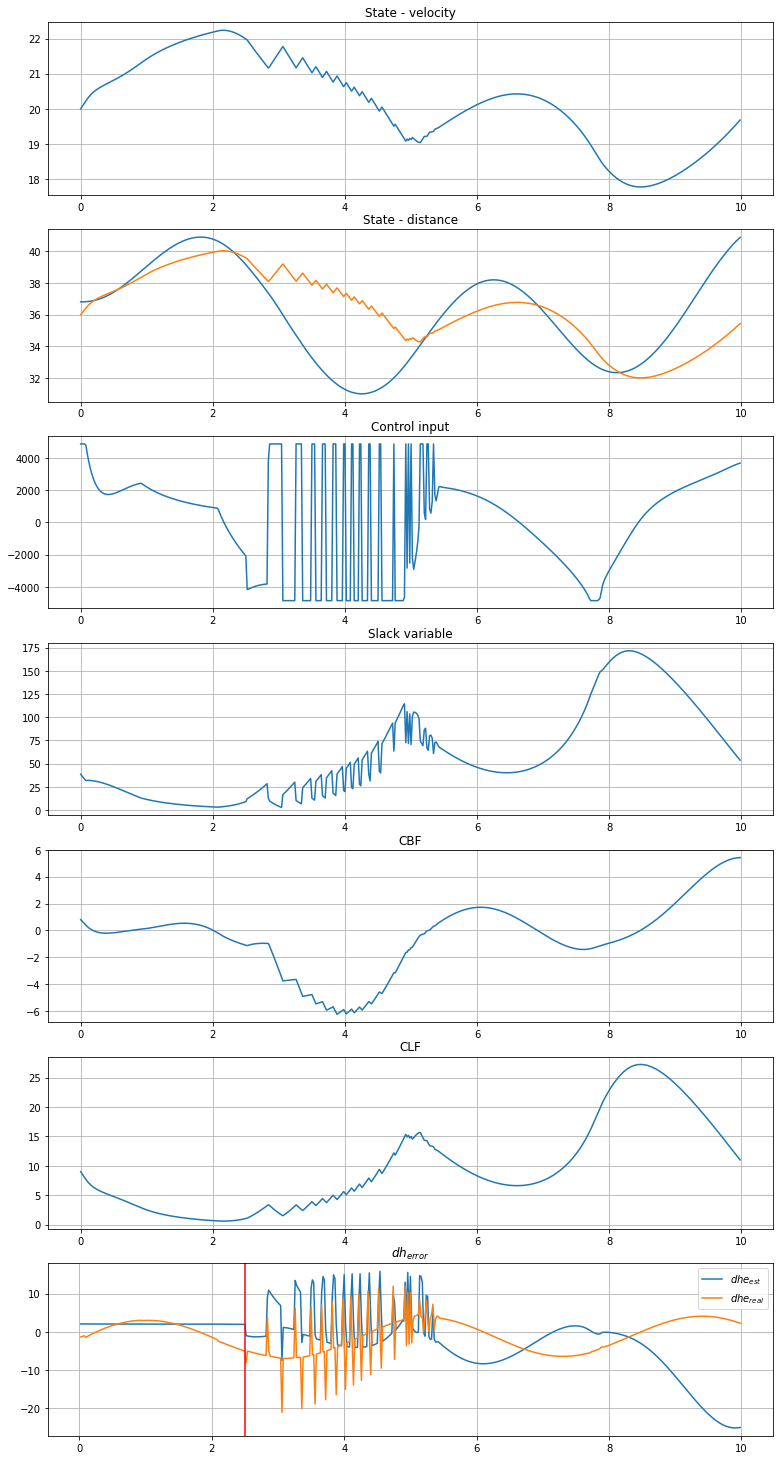

In [18]:

i = 3

f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(xs_lst)[i,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us_lst)[i,:])
ax[2].grid(True)
ax[2].set_title('Control input')


ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')


ax[4].plot(t_lns, np.array(hs_lst)[i,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


#ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])

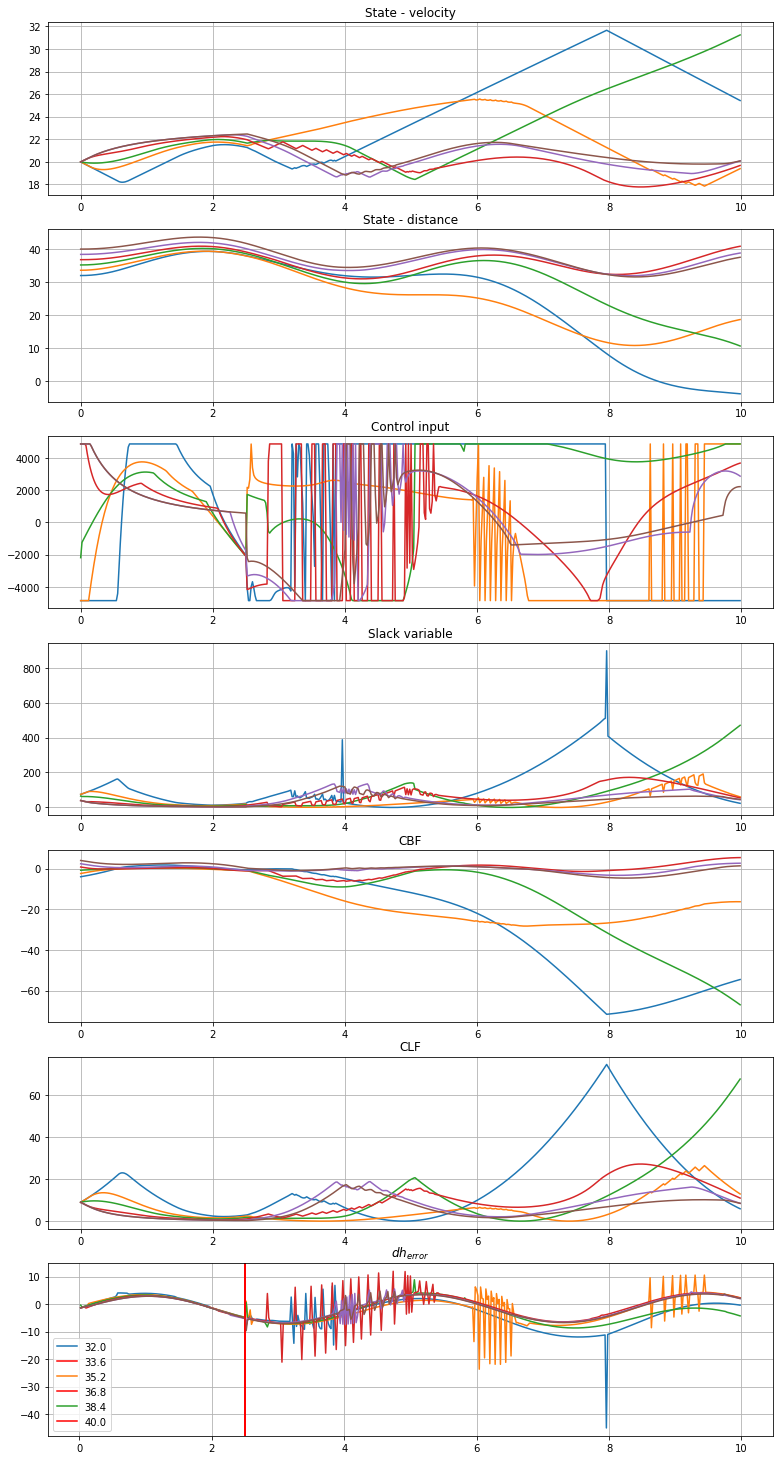

In [17]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

for i in range(laps):
    ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
    ax[0].grid(True)
    ax[0].set_title('State - velocity')
    
    ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
    ax[1].grid(True)
    ax[1].set_title('State - distance')
    
    #ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

    ax[2].plot(t_lns,  np.array(us_lst)[i,:])
    ax[2].grid(True)
    ax[2].set_title('Control input')
    

    ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
    ax[3].grid(True)
    ax[3].set_title('Slack variable')
    

    ax[4].plot(t_lns, np.array(hs_lst)[i,:])
    ax[4].grid(True)
    ax[4].set_title('CBF')

    ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
    ax[5].grid(True)
    ax[5].set_title('CLF')

    #ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
    ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
    ax[6].grid(True)
    ax[6].set_title('$dh_{error}$')
    ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
    

    #ax[6].set_ylim([-10,10])
    ax[6].legend(dlst)

    

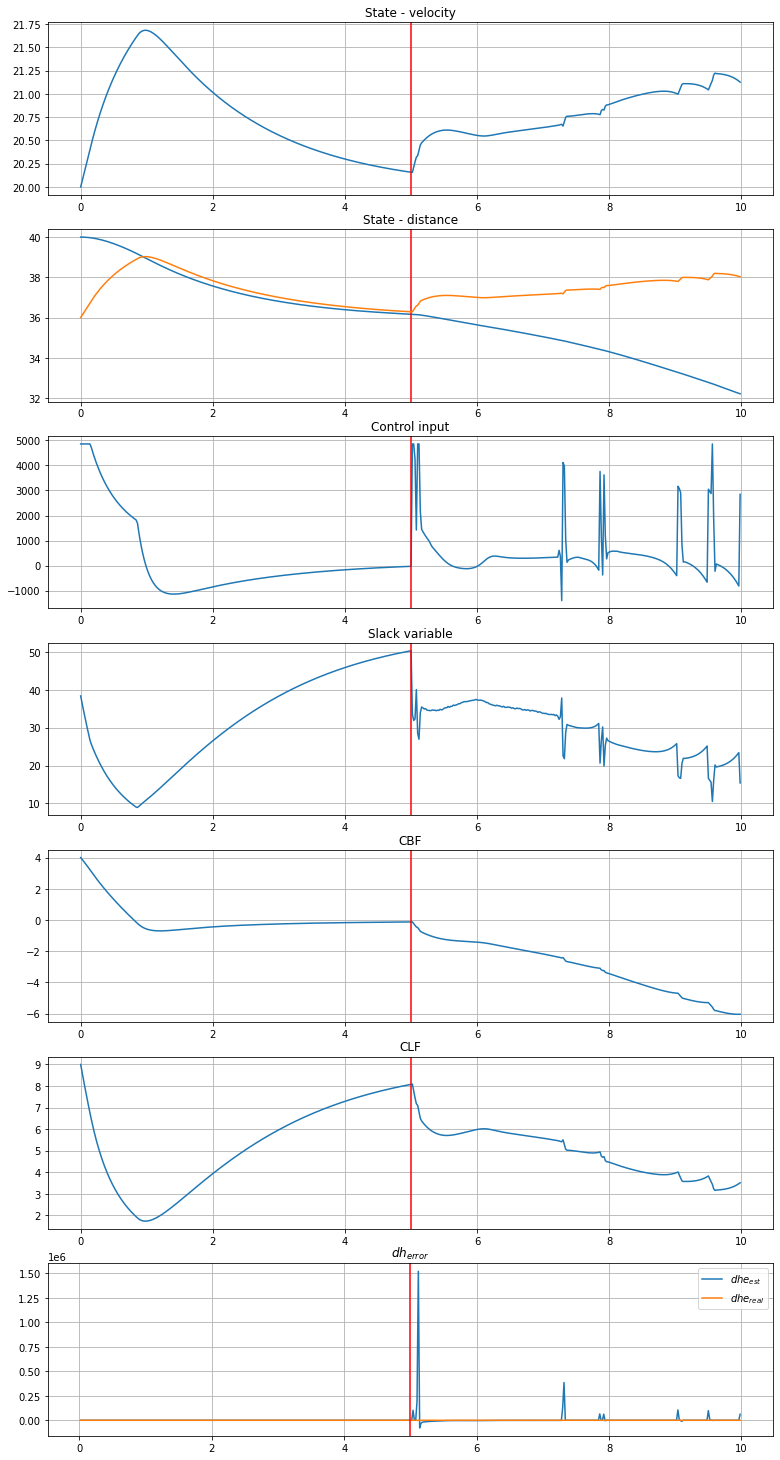

In [8]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')
ax[2].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')
ax[3].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[4].plot(t_lns, hs)
ax[4].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dhes[1:])
ax[6].plot(t_lns[1:], dhe_reals[1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


#ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])


In [31]:
estimator.e_fg.Omega

array([[-6.67065737e+04],
       [ 7.03441018e+04],
       [ 4.89362445e+04],
       [ 1.46052945e+05],
       [ 1.55217081e+05],
       [ 1.12055583e+05],
       [-1.73691840e+05],
       [-7.01699217e+04],
       [-5.32126312e+04],
       [-7.07795836e+04],
       [-7.16251767e+04],
       [ 5.31127353e+04],
       [ 6.47528536e+03],
       [-3.73245699e+04],
       [ 1.67206139e+05],
       [-5.38402190e+04],
       [ 1.03939099e+03],
       [ 4.85093717e+04],
       [-1.76302761e+03],
       [ 3.22879041e+05],
       [-5.76828661e+05],
       [-4.59673772e+02],
       [ 2.72105027e+04],
       [-3.34136321e+05],
       [-1.02107038e+04],
       [ 2.63585206e+04],
       [-5.48998878e+04],
       [-3.67638363e+04],
       [-1.20634596e+05],
       [-9.48756103e+04],
       [-5.75632190e+04],
       [-1.09685150e+05],
       [ 3.52638862e+04],
       [ 9.54623980e+04],
       [ 3.45147138e+04],
       [ 2.36944862e+04],
       [-1.82481526e+05],
       [-6.32014309e+04],
       [ 5.9

In [13]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)


n_hidden = 60
estimator = OSELMRegressor(n_hidden=n_hidden, activation_func='sigmoid', random_state=123)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
B_perf_lst = []
slack_lst = []


dBe_lst = []


x_initial = []
y_initial = []


x0 = sample_initial_state()
x = x0
derivator = Derivator(dt)


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    B_perfs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        dBe_est, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, estimator, weights)
        
        B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        B_perfs.append(B_perf)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)
    B_perf_lst.append(B_perfs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        



NameError: name 'v_ego' is not defined

### No training

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

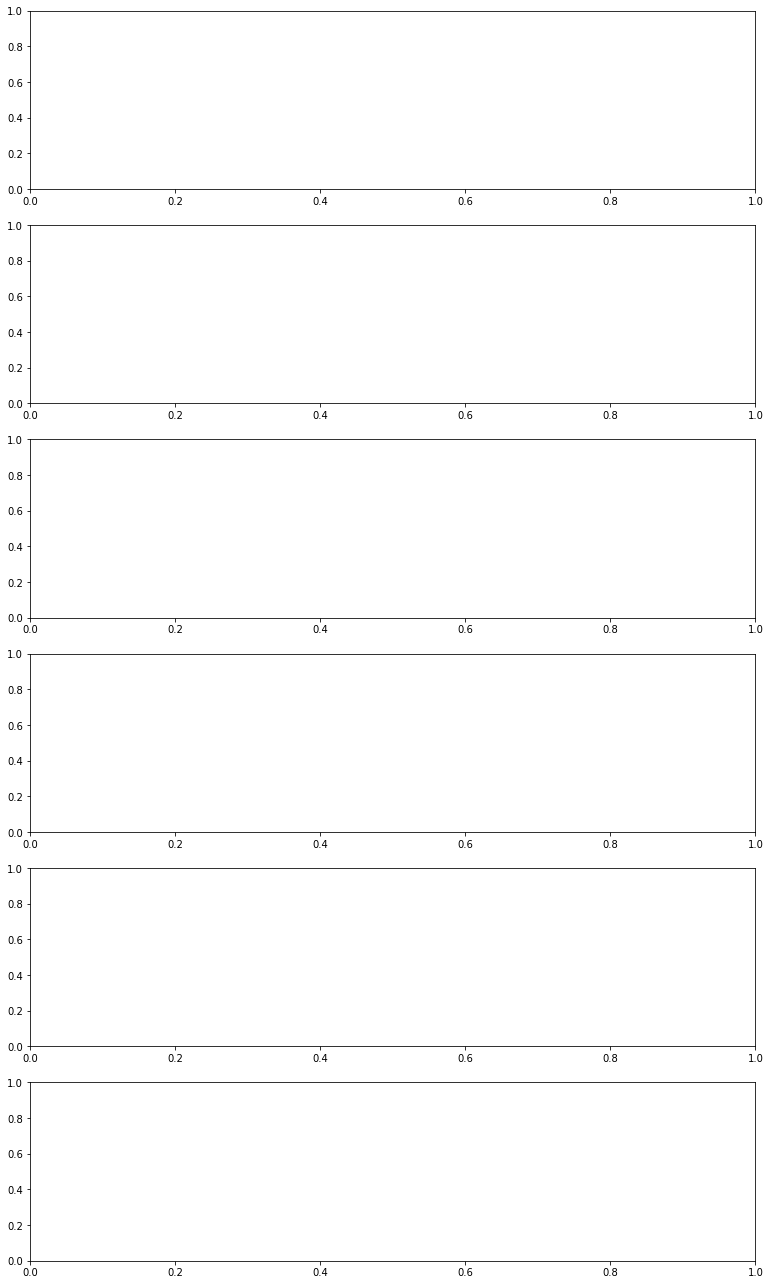

In [ ]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)
exp = 1


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')


In [ ]:
t_lns.shape

(500,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

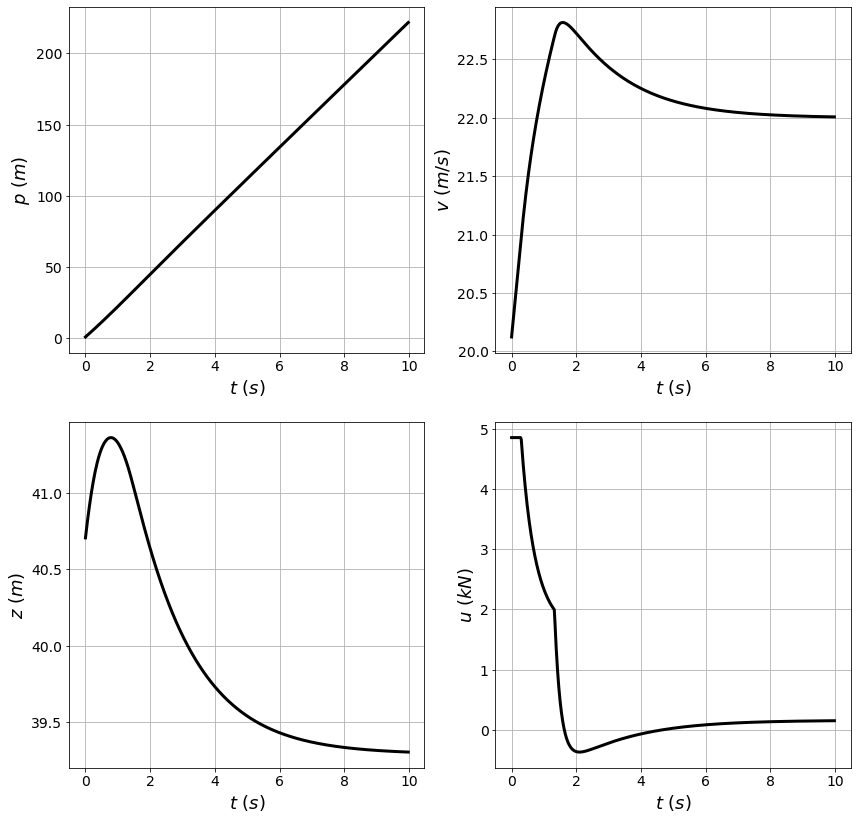

In [ ]:
f,ax = plt.subplots(2,2,figsize = (14,14))
t_lns = np.arange(0, 10, dt)
exp = 9

ax[0,0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0,0].grid(True)
ax[0,0].set_ylabel('$p$ $(m)$', fontsize = 18)
ax[0,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

ax[0,1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[0,1].grid(True)
ax[0,1].set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax[0,1].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,1].set_title('State - velocity')

ax[1,0].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[1,0].grid(True)
ax[1,0].set_ylabel('$z$ $(m)$', fontsize = 18)
ax[1,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1,0].set_title('State - distance')

ax[1,1].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[1,1].grid(True)
ax[1,1].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[1,1].set_xlabel('$t$ $(s)$', fontsize = 18)
#ax[1,1].tick_params(fontsize=14)
plt.yticks(fontsize=14)
plt.setp(ax[0,0].get_xticklabels(), fontsize=14)
plt.setp(ax[0,0].get_yticklabels(), fontsize=14)

plt.setp(ax[0,1].get_xticklabels(), fontsize=14)
plt.setp(ax[0,1].get_yticklabels(), fontsize=14)

plt.setp(ax[1,0].get_xticklabels(), fontsize=14) 
plt.setp(ax[1,0].get_yticklabels(), fontsize=14)



plt.setp(ax[1,1].get_xticklabels(), fontsize=14)
plt.setp(ax[1,1].get_yticklabels(), fontsize=14)


#ax[1,1].set_title('State - distance')

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

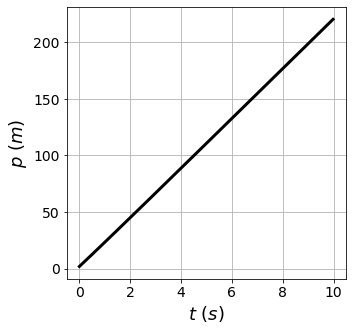

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 9

ax.plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$p$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

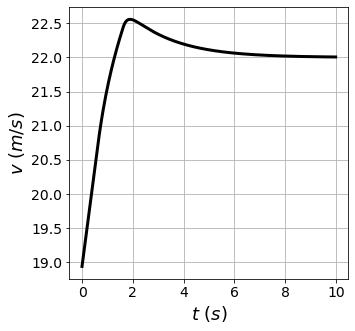

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75, 41.  ,
        41.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

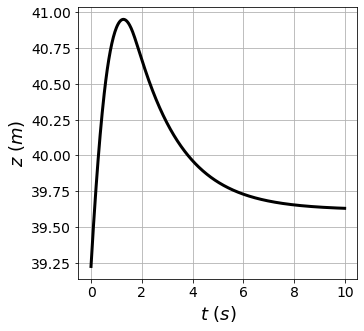

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,2], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$z$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

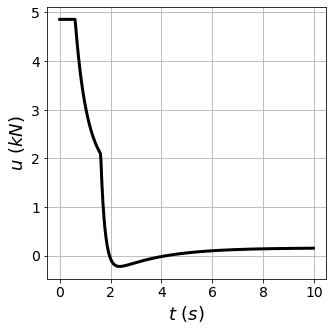

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$u$ $(kN)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

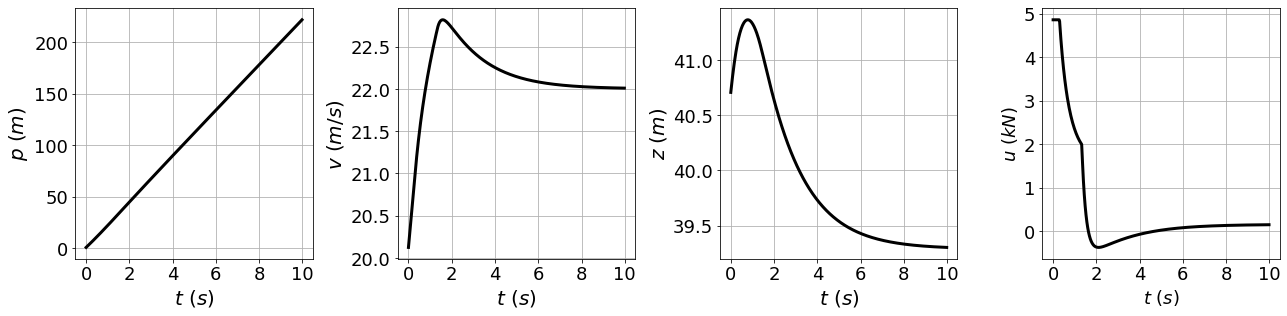

In [ ]:
f,ax = plt.subplots(1,4,figsize = (18,4.5))
t_lns = np.arange(0, 10, dt)
exp = 0

ax[0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0].grid(True)
ax[0].set_ylabel('$p$ $(m)$', fontsize = 20)
ax[0].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[1].grid(True)
ax[1].set_ylabel('$v$ $(m/s)$', fontsize = 20)
ax[1].set_xlabel('$t$ $(s)$', fontsize = 20)


ax[2].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[2].grid(True)
ax[2].set_ylabel('$z$ $(m)$', fontsize = 20)
ax[2].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[3].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[3].grid(True)
ax[3].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[3].set_xlabel('$t$ $(s)$', fontsize = 18)



plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)

plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

plt.setp(ax[2].get_xticklabels(), fontsize=18) 
plt.setp(ax[2].get_yticklabels(), fontsize=18)

plt.setp(ax[3].get_xticklabels(), fontsize=18)
plt.setp(ax[3].get_yticklabels(), fontsize=18)

f.tight_layout() 
#ax[1,1].set_title('State - distance')

### Barrier function

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

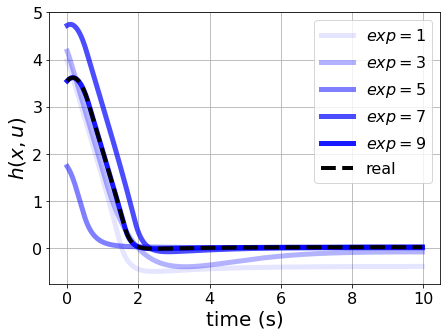

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0



for exp in range(10):
    if exp % 2 == 0:
        h = np.array(x_lst)[exp,start:,2] - Th*np.array(x_lst)[exp,start:,1]  - 0.5*(np.array(x_lst)[exp,start:,1] - v_ego)/c_d/g
        h = np.array(B_lst)[exp,start:]
        ax.plot(t_lns[start:], h , 'blue', alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'black',linewidth = 4, linestyle = '--')

ax.grid(True)
#ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 20)
ax.set_ylabel('$h(x, u)$', fontsize= 20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



### Lyapunov function

Text(0, 0.5, '$V(x, u)$')

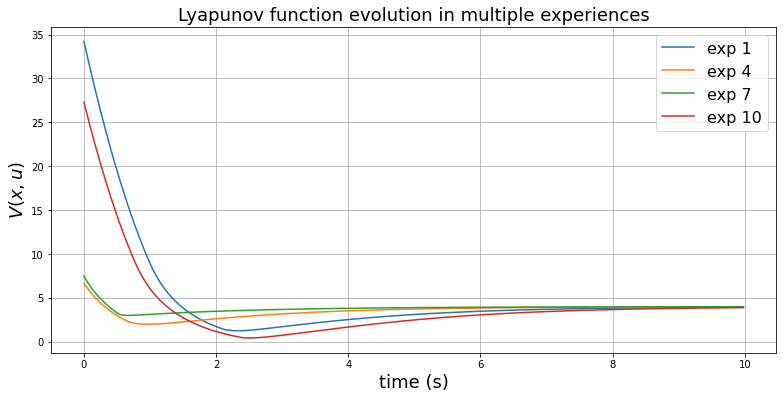

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 3 == 0:
        V = np.array(V_lst)[exp,start:]
        ax.plot(t_lns[start:], V )
        #print(exp)
        
ax.grid(True)
ax.set_title('Lyapunov function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

### Comparison with perfect knowledge

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

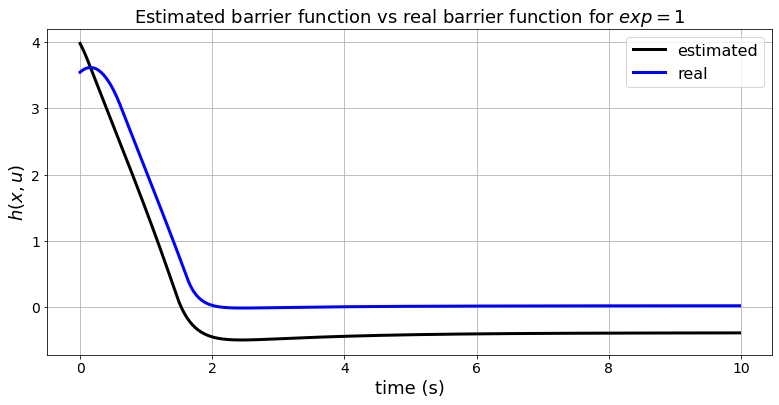

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 0

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'blue',linewidth = 3)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs real barrier function for $exp = 1$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

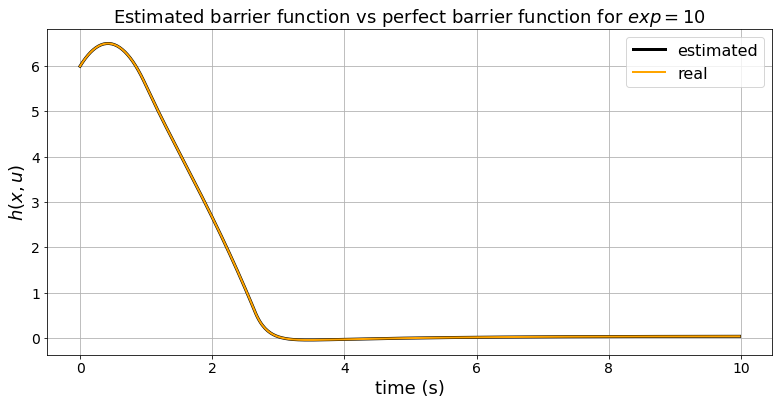

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'orange',linewidth = 2)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs perfect barrier function for $exp = 10$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Estimator evolution

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

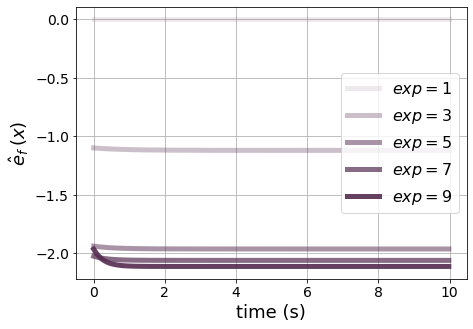

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(a_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V , color = (0.329, 0.168, 0.313), alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_f$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_f\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

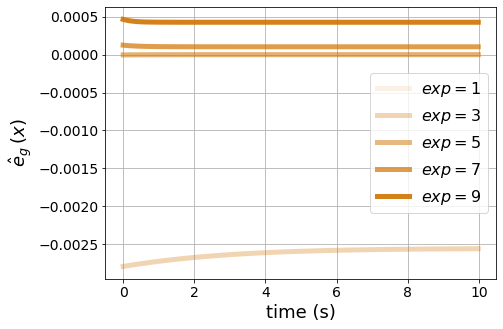

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(b_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V, color = (0.819, 0.450, 0), alpha = 0.1 * (exp + 1), linewidth = 5 )
        #print(exp) 
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_g$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_g\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

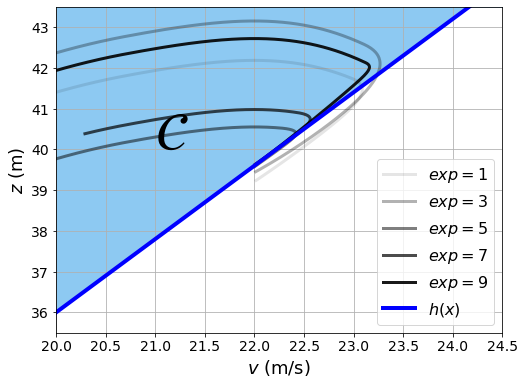

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

#h_perf = np.array(B_perf_lst)[exp,start:]

for exp in range(10):
    if exp % 2 == 0:
        z = np.array(x_lst)[exp,start:,2]# np.array(B_lst)[exp,start:]
        v = np.array(x_lst)[exp,start:,1]
        ax.plot(v, z, 'black', alpha = 0.1 * (exp + 1), linewidth = 3)
        

        
        
ax.grid(True)
#ax.set_title('Safe distance performance vs velocity. $z \geq T_h v$', fontsize= 18)
#ax.legend(['estimated','real'],fontsize= 16) 
ax.set_ylabel('$z$ (m)', fontsize= 18)
ax.set_xlabel('$v$ (m/s)', fontsize= 18)

v_min = 20
v_max = 24.5
z_min = 35.5
z_max = 43.5

v_span = np.linspace(v_min, v_max, 50)
ax.plot(v_span, v_span*Th, 'blue',linewidth = 4 )


ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','$h(x)$'],fontsize= 16) 
plt.gca().fill_between(v_span, v_span*Th, z_max, v_span > 0, color = (0.552, 0.788, 0.949))
ax.set_ylim(z_min, z_max)
ax.set_xlim(v_min, v_max)

ax.text(21,40,'$\mathcal{C}$', fontsize=54)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0

for exp in range(10):
    if exp % 3 == 0:
        h_ = np.array(B_perf_lst)[exp,start:]
        ax.plot(t_lns[start:], h )
        #print(exp)
        
ax.grid(True)
ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

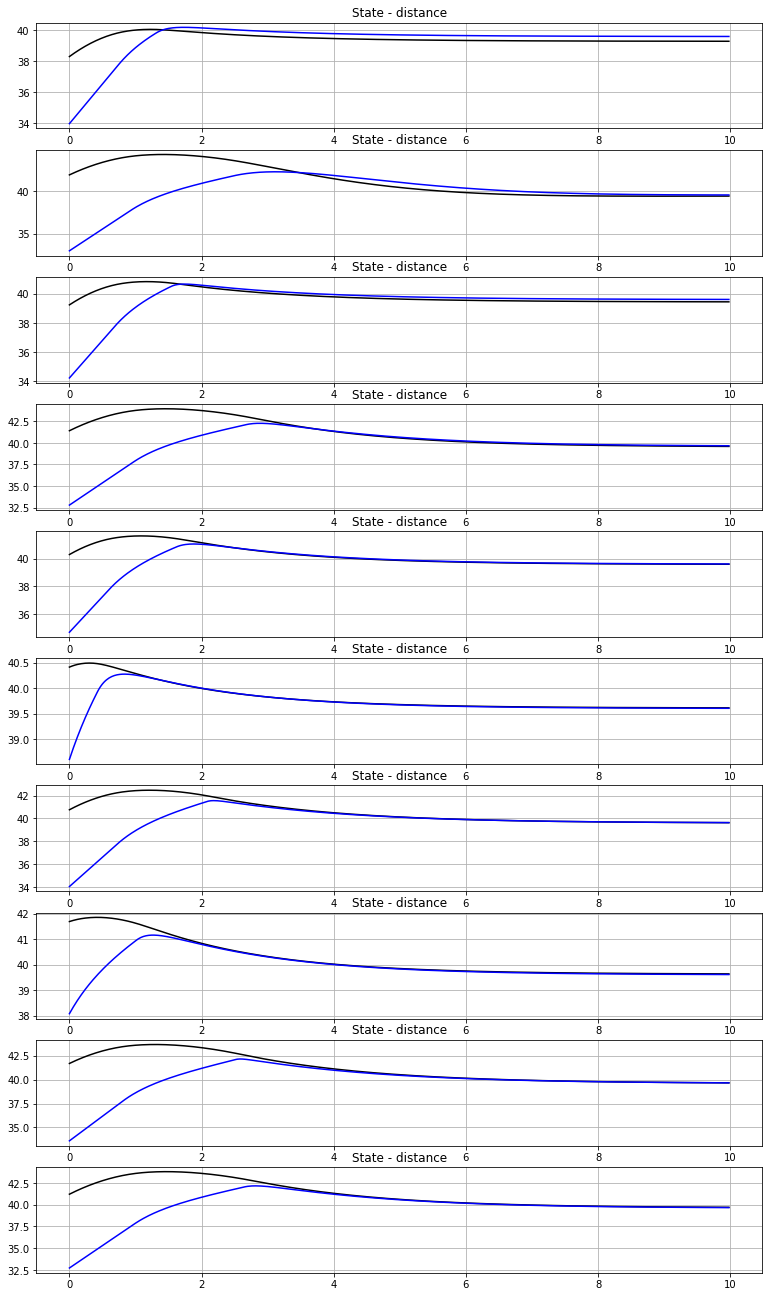

In [ ]:
f,ax = plt.subplots(10,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)

for exp in range(10):
    ax[exp].plot(t_lns, np.array(x_lst)[exp,:,2],'black')
    ax[exp].grid(True)
    ax[exp].set_title('State - distance')

    ax[exp].plot(t_lns, Th*np.array(x_lst)[exp,:,1], 'blue')

### First time

In [ ]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-4)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-4)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


a_h_lst = []
b_h_lst = []


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    # Train
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
    
    # Test
    x = [0,20,40]
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
 
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        

